In [10]:
import json
import jsonlines
import pickle
import pandas as pd
import numpy as np
from scipy.stats import entropy
from scipy.spatial import distance
from scipy.stats import chisquare
from scipy.stats import kstest
import matplotlib


def get_top_k_count(real_topk, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json part for real_topk and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    t1 = 0
    t2 = 0
    t3 = 0
    t4 = 0
    for item in real_topk:
        if(item[0] < top1):
            t1 = t1 + 1
        elif(item[0] < top2):
            t2 = t2 + 1
        elif(item[0] < top3):
            t3 = t3 + 1
        else:
            t4 = t4 + 1
    return [t1, t2, t3, t4]


def get_top_k_count_from_file(json_file, top1 = 10, top2 = 100, top3 = 1000):
    # takes in the json file and returns the counts of top1,2,3,4
    # top4 is just whatever is past the last number, for example >1000
    # returns list in order of top1 to top4 bins
    return get_top_k_count(json_file["result"]["real_topk"], top1, top2, top3)


def get_frac_p(real_topk, pred_topk):
    # takes in real_topk and pred_topk and returns list of
    # frac(p)
    res = []
    for i in range(len(real_topk)):
        res.append(real_topk[i][1] / pred_topk[i][0][1])
    return res


def fracp_bin_counter(fracp):
    # takes in the list of all frac(p) and returns list of buckets from 0-1
    # counting by 0.1
    b0 = 0
    b1 = 0
    b2 = 0
    b3 = 0
    b4 = 0
    b5 = 0
    b6 = 0
    b7 = 0
    b8 = 0
    b9 = 0

    for val in fracp:
        if(val <= 0.1):
            b0 = b0 + 1
        elif(val <= 0.2):
            b1 = b1 + 1
        elif(val <= 0.3):
            b2 = b2 + 1
        elif (val <= 0.4):
            b3 = b3 + 1
        elif (val <= 0.5):
            b4 = b4 + 1
        elif (val <= 0.6):
            b5 = b5 + 1
        elif (val <= 0.7):
            b6 = b6 + 1
        elif (val <= 0.8):
            b7 = b7 + 1
        elif (val <= 0.9):
            b8 = b8 + 1
        else:
            b9 = b9 + 1
    # print([b0, b1, b2, b3, b4, b5, b6, b7, b8, b9])
    return [b0, b1, b2, b3, b4, b5, b6, b7, b8, b9]


def fracp_bin_counter_from_file(json_file):
    # takes json file (json structure) and returns bins count
    rtk = json_file["result"]["real_topk"]
    ptk = json_file["result"]["pred_topk"]
    return fracp_bin_counter(get_frac_p(rtk, ptk))


def zero_to_small_num(lst):
    # takes a list and replaces all 0 with a small number
    for i in range(len(lst)):
        if lst[i] == 0:
            lst[i] = 0.0000000000000000000001
    return lst


def get_kld(fp_bin1, fp_bin2):
    # given two list of bin counts (10 long by default)
    # returns KLD value
    return entropy(fp_bin1, fp_bin2)


def get_kld_from_json_file(file1, file2):
    # given two json objects
    # returns KLD value
    # this skips a lot of steps to make it easier
    realtk_1 = file1["result"]["real_topk"]
    predtk_1 = file1["result"]["pred_topk"]
    realtk_2 = file2["result"]["real_topk"]
    predtk_2 = file2["result"]["pred_topk"]

    bins1 = fracp_bin_counter(get_frac_p(realtk_1, predtk_1))
    bins2 = fracp_bin_counter(get_frac_p(realtk_2, predtk_2))
    print(str(bins1) + "                   " + str(bins2))
    # bins1 = zero_to_small_num(bins1)
    # bins2 = zero_to_small_num(bins2)
    print(str(bins1) + "                   " + str(bins2))
    return get_kld(bins1, bins2)


def get_jsd(fp_bin1, fp_bin2):
    # given two list of bin counts, (10 long by default)
    # returns JSD value
    return distance.jensenshannon(fp_bin1, fp_bin2)


def compare_json_files_kld(filename1, filename2):
    # given two file names, get json from it, then use kld
    # returns list of all kld values
    lst = []
    with open(filename1) as f1:
        d1 = json.load(f1)
    with open(filename2) as f2:
        d2 = json.load(f2)
    print(str(len(d1))+"       F2:"+str(len(d2)))

    for d1x in d1:
        for d2x in d2:
            # print("D1: " + str(d1x) + "           D2: " + str(d2x))
            lst.append(get_kld_from_json_file(d1x, d2x))
            print(lst[-1])
    return lst


def list_of_fracp_from_file(filename):
    # given two file names, get json from it, then return list
    # returns list of list of 10 frac p bins
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)

    for d1x in d1:
        lst.append(fracp_bin_counter_from_file(d1x))
    return lst


def list_of_fracp_from_jsonl_file(filename):
    # given two file names of json lines, get json from it, then return list
    # returns list of list of 10 frac p bins
    lst = []
    with jsonlines.open(filename) as reader:
        for obj in reader:
            lst.append(fracp_bin_counter_from_file(obj))
    return lst


def list_of_norm_fracp_from_file(filename):
    # given two file names, get json from it, then return list
    # returns list of list of 10 frac p bins that are normalized
    lst = []
    with open(filename) as f1:
        d1 = json.load(f1)

    for d1x in d1:
        bins = fracp_bin_counter_from_file(d1x)
        tot = sum(bins)
        for i in range(10):
            bins[i] = bins[i] / tot
        print(sum(bins))
        lst.append(bins)
    return lst

#### List of pickles to use
- "fracp.GPT2-human-25000-pd-normalized.pickle"
- "fracp.GPT2-machine-25000-pd-normalized.pickle"
- "fracp.GROVER-human-15000-pd-normalized.pickle"
- "fracp.GROVER-machine-10000-pd-normalized.pickle"
- "fracp.GPT3-machine-485-pd-normalized.pickle"

              0         1         2         3         4         5         6  \
0      0.209524  0.061905  0.047619  0.023810  0.047619  0.023810  0.009524   
1      0.277978  0.106498  0.055957  0.043321  0.028881  0.034296  0.023466   
2      0.274725  0.098901  0.054945  0.071429  0.016484  0.038462  0.038462   
3      0.254296  0.092784  0.054983  0.037801  0.034364  0.027491  0.030928   
4      0.211009  0.082569  0.055046  0.036697  0.027523  0.027523  0.045872   
...         ...       ...       ...       ...       ...       ...       ...   
24994  0.328859  0.134228  0.060403  0.040268  0.040268  0.020134  0.033557   
24995  0.290055  0.096685  0.049724  0.041436  0.052486  0.038674  0.024862   
24996  0.265734  0.087413  0.055944  0.050117  0.025641  0.022145  0.025641   
24997  0.230769  0.089397  0.058212  0.035343  0.037422  0.039501  0.018711   
24998  0.250399  0.108453  0.060606  0.051037  0.043062  0.044657  0.022329   

              7         8         9  
0      0.0333

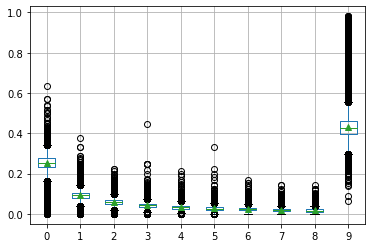

In [13]:
%matplotlib inline
observed = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle")
print(observed)
observed.boxplot()

In [9]:
observed = pd.read_pickle("fracp.GPT2-machine-25000-pd-normalized.pickle").mean(axis=0)
expected = pd.read_pickle("fracp.GPT2-human-25000-pd-normalized.pickle").replace(0, 0.00000000000000000000000000000001).mean(axis=0)
chi_res = chisquare(observed, expected, 0, 0)
print(chi_res)

Power_divergenceResult(statistic=0.031895314243821415, pvalue=0.999999999845967)
